In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_214708/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)


In [3]:


def take_rmse_average_at_level_and_variable(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_1_9_20110101_20120101/mean_output/out.nc'
    
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_mem_1_fixed_20110101_20120115/out.nc'
    
    anal_era5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_hybrid_1_9_20110101_20120101/mean_output/out.nc'#_older_stuff/ERA5_1_9/mean_output/out.nc' # ONLY 3 months :(
    
    hybrid_2nd_iter_anal_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_9_1_9_1_7_20110101_20120101/mean_output/out.nc'
    
    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
#     enddate = datetime(2011,12,31,18)
    enddate = datetime(2011,12,31,18)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4

    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .835:
        level_in_era = 6
    if level_in_speedy == .685:
        level_in_era = 5
    if level_in_speedy == .51:
        level_in_era = 4
    if level_in_speedy == .34:
        level_in_era = 3
    if level_in_speedy == .2:
        level_in_era = 2
    if level_in_speedy == .095:
        level_in_era = 1
    if level_in_speedy == .025:
        level_in_era = 0
#     print(level_in_era)    
    level_era = level_in_era

    var_da = variable_speedy
    
    
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    timestep_6hrly = 6


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
    temp_500_nature = ds_nature.values

    ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
    ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    # add ERA5
    ds_era5trained_anal_mean = xr.open_dataset(anal_era5_file)[var_da].sel(lev=level,time=time_slice)
    
    #2nd iter
    ds_2nditer_hybrid = xr.open_dataset(hybrid_2nd_iter_anal_file)[var_da].sel(lev=level,time=time_slice)
    
                                                                   
    temp_500_analysis = ds_analysis_mean

    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    # temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
    # temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values



    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    #find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    hybrid_2ndindex = ds_2nditer_hybrid.shape[0]
    
    smallest_index = min(speedy_index,nature_index,hybrid_index,hybrid_2ndindex)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    elif smallest_index == hybrid_index:
        length = hybrid_index
    else:
        length = hybrid_2ndindex
        
    print('the smallest length is',length)

    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    # global_average_ensemble_spread_hybrid = np.zeros((length))
    # global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))
    anal_rmse_era5trained = np.zeros((length))
    anal_rmse_hybrid_2nd_iter = np.zeros((length))
    
    
    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    for i in range(length):
        analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        anal_rmse_era5trained[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_era5trained_anal_mean[i,:,:],lats)
        anal_rmse_hybrid_2nd_iter[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],ds_2nditer_hybrid[i,:,:],lats)
        
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
#         analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
#         analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    #     global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
    #     global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')
    ## MAKING AVERAGES
    
    global average_hybrid
    average_hybrid = np.average(analysis_rmse)
    print('average Hybrid ', average_hybrid)
    
    global average_hybrid2iter
    average_hybrid2iter = np.average(anal_rmse_hybrid_2nd_iter)
    print('average hybrid 2nditer', average_hybrid2iter)
    
    global average_speedy
    average_speedy = np.average(analysis_rmse_speedy)
    print('average speedy ', average_speedy)
    
    global average_era5trained
    average_era5trained = np.average(anal_rmse_era5trained)
    print('average_era5trained ', average_era5trained)
    print('Done with analysis.')    

In [4]:
# testing

speedy_file_type_list_of_levels = [0.95, 0.835, 0.685, 0.51, 0.34 , 0.2, 0.095, 0.025]
variable_list_speedy = ['q','u','t','v']

average_list_hybrid_q = []    
average_list_speedy_q = []
average_list_hybrid_v = []
average_list_speedy_v = []
average_list_hybrid_t = []    
average_list_speedy_t = []
average_list_hybrid_u = []
average_list_speedy_u = []
average_list_era5trained_q = []
average_list_era5trained_v = []
average_list_era5trained_t = []
average_list_era5trained_u = []
average_list_hybrid_2nditer_q = []
average_list_hybrid_2nditer_v = []
average_list_hybrid_2nditer_t = []
average_list_hybrid_2nditer_u = []
 
# loop
for level in speedy_file_type_list_of_levels:
    for variable in variable_list_speedy: 
        take_rmse_average_at_level_and_variable(level,variable)
        
        if variable == 'q':
            average_list_hybrid_q.append(average_hybrid)
            average_list_speedy_q.append(average_speedy)
            average_list_era5trained_q.append(average_era5trained)
            average_list_hybrid_2nditer_q.append(average_hybrid2iter)
        elif variable == 'u':
            average_list_hybrid_u.append(average_hybrid)
            average_list_speedy_u.append(average_speedy)
            average_list_era5trained_u.append(average_era5trained)
            average_list_hybrid_2nditer_u.append(average_hybrid2iter)
        elif variable == 'v':
            average_list_hybrid_v.append(average_hybrid)
            average_list_speedy_v.append(average_speedy)
            average_list_era5trained_v.append(average_era5trained)
            average_list_hybrid_2nditer_v.append(average_hybrid2iter)
        elif variable == 't':
            average_list_hybrid_t.append(average_hybrid)
            average_list_speedy_t.append(average_speedy)
            average_list_era5trained_t.append(average_era5trained)
            average_list_hybrid_2nditer_t.append(average_hybrid2iter)
        
            
        print('average list hybrid_q check:', average_list_hybrid_q)
        print('average list speedy_q check:', average_list_speedy_q)
        print('average list era5_q check:', average_list_era5trained_q)
        print('average list hybrid_2nditer_q check:', average_list_hybrid_2nditer_q)
        print('average list hybrid_u check:', average_list_hybrid_u)
        print('average list speedy_u check:', average_list_speedy_u)
        print('average list era5_u check:', average_list_era5trained_u)
        print('average list hybrid_2nditer_u check:', average_list_hybrid_2nditer_u)
        print('average list hybrid_v check:', average_list_hybrid_v)
        print('average list speedy_v check:', average_list_speedy_v)
        print('average list era5_v check:', average_list_era5trained_v)
        print('average list hybrid_2nditer_v check:', average_list_hybrid_2nditer_v)
        print('average list hybrid_t check:', average_list_hybrid_t)
        print('average list speedy_t check:', average_list_speedy_t)
        print('average list era5_t check:', average_list_era5trained_t)
        print('average list hybrid_2nditer_t check:', average_list_hybrid_2nditer_t)

        
print('Vertical profile of era5trained hybrid q ', average_list_era5trained_q)
    

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  0.001428976238064136
average hybrid 2nditer 0.0015468740811067545
average speedy  0.0014299336098427947
average_era5trained  0.0007379866322368536
Done with analysis.
average list hybrid_q check: [0.001428976238064136]
average list speedy_q check: [0.0014299336098427947]
average list era5_q check: [0.0007379866322368536]
average list hybrid_2nditer_q check: [0.0015468740811067545]
average list hybrid_u check: []
average list speedy_u check: []
average list era5_u check: []
average list hybrid_2nditer_u check: []
average list hybrid

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.4392746900042444
average hybrid 2nditer 1.4665534106019424
average speedy  1.5256056170757504
average_era5trained  1.0132861671382434
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843]
average list hybrid_2nditer_q check: [0.0015468740811067545, 0.0012809889585621756]
average list hybrid_u check: [2.6850557240721296, 2.512165847216567]
average list speedy_u check: [2.7220851390329126, 2.6381532113846036]
average list era5_u check: [1.7770740070571638, 1.945712990221912]
average list hybrid_2nditer_u che

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.422578374000445
average hybrid 2nditer 2.4369329940782833
average speedy  2.5788158769476905
average_era5trained  2.134506568026869
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092]
average list hybrid_2nditer_q check: [0.0015468740811067545, 0.0012809889585621756, 0.0010260002594680384]
average list hybrid_u check: [2.6850557240721296, 2.512165847216567, 2.4797600066825134]
average list speedy_u check: [2.7220851390329126, 2.6381532113

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.8853326897098595
average hybrid 2nditer 2.8947211476221475
average speedy  3.0935339238545665
average_era5trained  2.6512991828461216
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.0005495327051803917]
average list hybrid_2nditer_q check: [0.0015468740811067545, 0.0012809889585621756, 0.0010260002594680384, 0.0006005957613026162]
average list hybrid_u check: [2.6850557240721296, 2.512165

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  4.003200174684394
average hybrid 2nditer 3.9756093582061873
average speedy  4.3225072589639115
average_era5trained  3.6228112013372655
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848, 0.00026638377586432274]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718, 0.00027163154039929035]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.0005495327051803917, 0.0001361963350313065]
average list hybrid_2nditer_q check: [0.0015468740811067545, 0.0012809889585621756, 0.0010260002594680384, 0.000600595

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.3037098795583804
average hybrid 2nditer 1.2740131837047943
average speedy  1.5883822846086058
average_era5trained  1.019875601097329
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848, 0.00026638377586432274, 3.967479380214035e-05]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718, 0.00027163154039929035, 4.057513664744488e-05]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.0005495327051803917, 0.0001361963350313065, 9.98814248056103e-06]
average list hybrid_2nditer_q check: [0.0015468740

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.193442579573148
average hybrid 2nditer 2.192794935017416
average speedy  2.4997419533664234
average_era5trained  1.9381094181374328
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848, 0.00026638377586432274, 3.967479380214035e-05, 1.786565120685375e-06]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718, 0.00027163154039929035, 4.057513664744488e-05, 1.7954812372172206e-06]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.0005495327051803917, 0.0001361963350313065, 9.98814248056103e-06, 3.45

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  1.8808085448112351e-06
average hybrid 2nditer 1.8808085448112351e-06
average speedy  1.8808085448112351e-06
average_era5trained  2.387786459126327e-07
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848, 0.00026638377586432274, 3.967479380214035e-05, 1.786565120685375e-06, 1.8808085448112351e-06]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718, 0.00027163154039929035, 4.057513664744488e-05, 1.7954812372172206e-06, 1.8808085448112351e-06]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.00054

Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
average Hybrid  2.6380997298515005
average hybrid 2nditer 2.6767062242716957
average speedy  2.8576965129538756
average_era5trained  2.219444251142136
Done with analysis.
average list hybrid_q check: [0.001428976238064136, 0.0012838813941925763, 0.0010437252898206168, 0.0006202568811976848, 0.00026638377586432274, 3.967479380214035e-05, 1.786565120685375e-06, 1.8808085448112351e-06]
average list speedy_q check: [0.0014299336098427947, 0.001333332510684196, 0.001117496491706458, 0.000647932633658718, 0.00027163154039929035, 4.057513664744488e-05, 1.7954812372172206e-06, 1.8808085448112351e-06]
average list era5_q check: [0.0007379866322368536, 0.0010498338578705843, 0.000921201771157092, 0.0005495327051803917, 

In [5]:
# convert to g/kg
average_list_era5trained_q_g_kg = [i * 1000 for i in average_list_era5trained_q]
average_list_hybrid_q_g_kg = [i * 1000 for i in average_list_hybrid_q]
average_list_speedy_q_g_kg = [i * 1000 for i in average_list_speedy_q]
average_list_hybrid2nditer_q_g_kg = [i * 1000 for i in average_list_hybrid_2nditer_q]

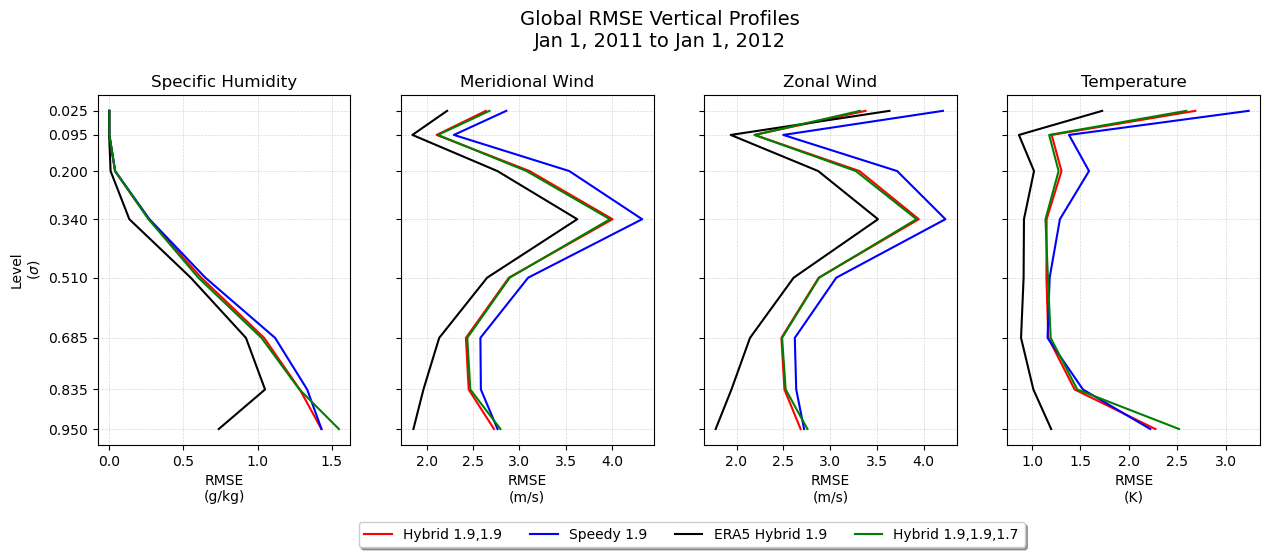

In [6]:
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)

# y-axis is height (in hPa)
y_axis = [1 * i for i in speedy_file_type_list_of_levels]
plt.gca().invert_yaxis()

# Set y-ticks
plt.yticks(speedy_file_type_list_of_levels)
i = 0
# for i in range(0,4,1):
while i < 4:
    axs[i].grid(color='lightgrey', linestyle='--', linewidth=0.45)
    i += 1
    
fig.subplots_adjust(top=0.81)
plt.suptitle('Global RMSE Vertical Profiles\nJan 1, 2011 to Jan 1, 2012\n ',fontsize=14)

# Plot for 'q'
axs[0].plot(average_list_hybrid_q_g_kg, y_axis, color='red')
axs[0].plot(average_list_speedy_q_g_kg, y_axis, color='blue')
axs[0].plot(average_list_era5trained_q_g_kg,y_axis,color='black')
axs[0].plot(average_list_hybrid2nditer_q_g_kg, y_axis,color='green')
axs[0].set_title('Specific Humidity')
axs[0].set_xlabel('RMSE\n(g/kg)')
axs[0].set_ylabel('Level\n($\sigma$)')

# Plot for 'v'
axs[1].plot(average_list_hybrid_v, y_axis, color='red')
axs[1].plot(average_list_speedy_v, y_axis, color='blue')
axs[1].plot(average_list_era5trained_v,y_axis,color='black')
axs[1].plot(average_list_hybrid_2nditer_v, y_axis,color='green')
axs[1].set_title('Meridional Wind')
axs[1].set_xlabel('RMSE\n(m/s)')
# Plot for 'u'
axs[2].plot(average_list_hybrid_u, y_axis, color='red')
axs[2].plot(average_list_speedy_u, y_axis, color='blue')
axs[2].plot(average_list_era5trained_u,y_axis,color='black')
axs[2].plot(average_list_hybrid_2nditer_u, y_axis,color='green')
axs[2].set_title('Zonal Wind')
axs[2].set_xlabel('RMSE\n(m/s)')
# Plot for 't'
axs[3].plot(average_list_hybrid_t, y_axis, color='red', label = "Hybrid 1.9,1.9")
axs[3].plot(average_list_speedy_t, y_axis, color='blue', label = 'Speedy 1.9')
axs[3].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 Hybrid 1.9")
axs[3].plot(average_list_hybrid_2nditer_t, y_axis,color='green',label = 'Hybrid 1.9,1.9,1.7' )
axs[3].set_title('Temperature')
axs[3].set_xlabel('RMSE\n(K)')

# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(-1.25, -0.2), fancybox=True, shadow=True, ncol=5)
# plt.tight_layout()
plt.savefig('figures_for_paper/Global_analysis_RMSE_Vertical_Profiles_full_year_1_9_s_8_19_24.png',bbox_inches='tight', dpi=1200)
plt.show()

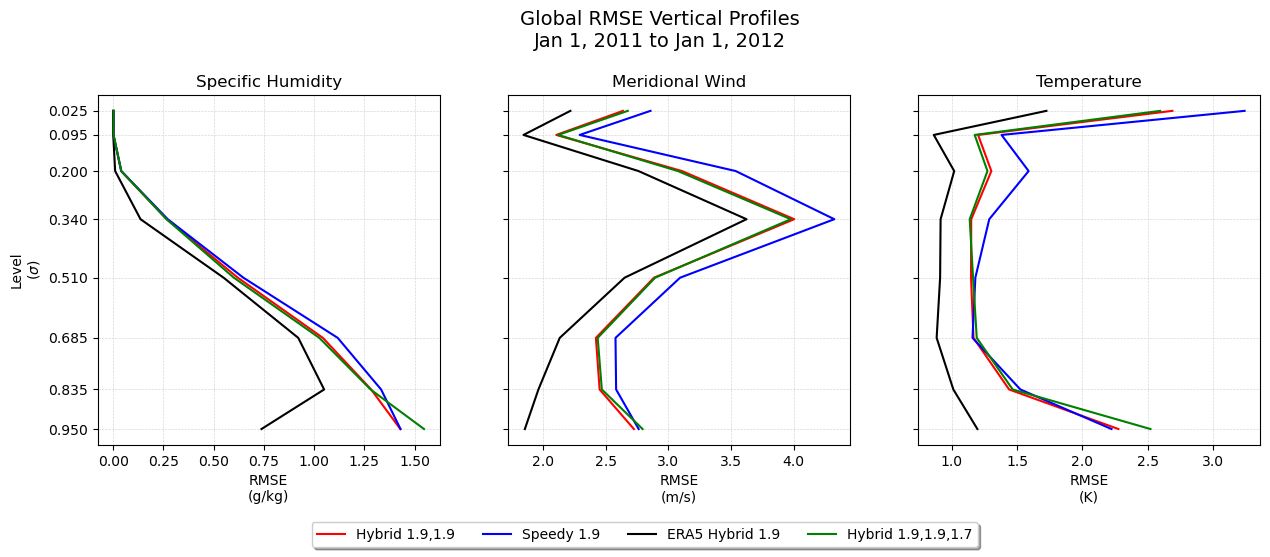

In [12]:
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# y-axis is height (in hPa)
y_axis = [1 * i for i in speedy_file_type_list_of_levels]
plt.gca().invert_yaxis()

# Set y-ticks
plt.yticks(speedy_file_type_list_of_levels)
i = 0
# for i in range(0,4,1):
while i < 3:
    axs[i].grid(color='lightgrey', linestyle='--', linewidth=0.45)
    i += 1
    
fig.subplots_adjust(top=0.81)
plt.suptitle('Global RMSE Vertical Profiles\nJan 1, 2011 to Jan 1, 2012\n ',fontsize=14)

# Plot for 'q'
axs[0].plot(average_list_hybrid_q_g_kg, y_axis, color='red')
axs[0].plot(average_list_speedy_q_g_kg, y_axis, color='blue')
axs[0].plot(average_list_era5trained_q_g_kg,y_axis,color='black')
axs[0].plot(average_list_hybrid2nditer_q_g_kg, y_axis,color='green')
axs[0].set_title('Specific Humidity')
axs[0].set_xlabel('RMSE\n(g/kg)')
axs[0].set_ylabel('Level\n($\sigma$)')

# Plot for 'v'
axs[1].plot(average_list_hybrid_v, y_axis, color='red')
axs[1].plot(average_list_speedy_v, y_axis, color='blue')
axs[1].plot(average_list_era5trained_v,y_axis,color='black')
axs[1].plot(average_list_hybrid_2nditer_v, y_axis,color='green')
axs[1].set_title('Meridional Wind')
axs[1].set_xlabel('RMSE\n(m/s)')
# # Plot for 'u'
# axs[2].plot(average_list_hybrid_u, y_axis, color='red')
# axs[2].plot(average_list_speedy_u, y_axis, color='blue')
# axs[2].plot(average_list_era5trained_u,y_axis,color='black')
# axs[2].plot(average_list_hybrid_2nditer_u, y_axis,color='green')
# axs[2].set_title('Zonal Wind')
# axs[2].set_xlabel('RMSE\n(m/s)')
# Plot for 't'
axs[2].plot(average_list_hybrid_t, y_axis, color='red', label = "Hybrid 1.9,1.9")
axs[2].plot(average_list_speedy_t, y_axis, color='blue', label = 'Speedy 1.9')
axs[2].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 Hybrid 1.9")
axs[2].plot(average_list_hybrid_2nditer_t, y_axis,color='green',label = 'Hybrid 1.9,1.9,1.7' )
axs[2].set_title('Temperature')
axs[2].set_xlabel('RMSE\n(K)')

# plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(-.8, -0.2), fancybox=True, shadow=True, ncol=5)
# plt.tight_layout()
plt.savefig('figures_for_paper/Global_analysis_RMSE_Vertical_Profiles_full_year_1_9_s_8_19_24_NO_U_WIND.png',bbox_inches='tight', dpi=1200)
plt.show()